In [85]:
%reset -f

In [86]:
import numpy as np

import os


From "Clever Algorithms": 
The Ant system algorithm is inspired by the foraging behavior of ants, specifically
the pheromone communication between ants regarding a good path
between the colony and a food source in an environment. This mechanism
is called stigmergy.

![title](Ant.jpg)

#### the classes Problem, Ant, AntcolonyTSP are loaded from file: before closing clean up and %writefile!

In [87]:
#%%writefile ../project/ant.py
# %load ../project/ant.py
#!/usr/bin/env python3



import numpy as np

import os

# Ants are the agents that perform the walks on the problem graph
# attributes:
    # size: number of cities
    # cities: array of indices of the cities
    # tour: array of cities in the order in which they were visited, returning to the starting point
    # tourlength: length of the tour as sum of distances in km
    # choices: array of probabilities with which a certain city will be chosen as the next to visit
    # candidate: bool, true if this ant's tour is a candidate for the optimal tour
class Ant:
    
    def __init__(self, problemsize):
        self.size = problemsize
        self.cities = np.arange(problemsize)
        self.tour = np.zeros(problemsize, 'i4')
        self.tourlength = 0
        self.choices = np.zeros(problemsize, 'f8')
        self.candidate = False
        
    
    # choose the next city to visit, given the current position and all probabilities  
    # TODO: WITH MASK, COPY WHEN DIVIDING
    def choosenext(self, position, probmatrix):
        self.choices = np.copy(probmatrix[position, :]) # copy row of position
        self.choices[self.tour] = 0. # set to 0 all probabilities referring to cities already visited
        s = self.choices.sum()
        self.choices /= s #DO copy here!!
        #return np.random.choice(self.cities, size=None, replace=True, p = self.choices) --> SLOW
        return np.random.multinomial(1,self.choices).argmax()
    
    # perform a walk on the graph, beginning and ending at position start
    # IN: start, current best tourlength, matrix of all distances, matrix of all probabilities
    def walk(self, start, currentbest, distmatrix, probmatrix):
        self.tourlength = 0
        self.tour = np.zeros(self.size, 'i4')
        i = start
        self.tour[0] = i # add city start to tour
        for k in range(1, self.size):
            j = self.choosenext(i, probmatrix) # choose next city
            self.tour[k] = j # add city to tour
            self.tourlength += distmatrix[i,j] # calculate traveled distance
            i = j # update current position
            if (self.tourlength > currentbest):
                return #return self.tourlength ?# stop if the tourlength exceeds current best tour before all cities are visited
        self.tourlength += distmatrix[j,start] # add distance of the return to start
        if (self.tourlength >= currentbest):
                return self.tourlength # if tourlength exceeds current best tour, it is not a candidate
        self.candidate = True
        return self.tourlength
    
    # given a known solution tour, perform the walk to calculate the length
    def solutionwalk(self, solution, distmatrix):
        self.tour = np.zeros(self.size, 'i4')
        self.tourlength = 0
        i = solution[0]
        for j in solution[1:]:
            self.tourlength += distmatrix[i,j]
            i=j
        self.tourlength += distmatrix[solution[-1], solution[0]]
        return self.tourlength
    
    # def naivewalk(self, distmatrix):
    #     randsol = np.random.permutation(self.size)
    #     self.tour = np.zeros(self.size, 'i4')
    #     self.tourlength = 0
    #     i = randsol[0]
    #     self.tour[0] = 0
    #     for j in randsol[1:]:
    #         self.tourlength += distmatrix[i,j]
    #         i=j
    #     self.tourlength += distmatrix[randsol[-1], randsol[0]]
    #     return self.tourlength

    # naivewalk as nearest neighbour tour: greedy solution
    def naivewalk(self, distmatrix):
        dist = distmatrix.astype(float)
        dist[np.where(dist == 0)] = np.inf
        dist[:,0] = np.inf
        self.tour = np.zeros(self.size, 'i4')
        self.tourlength = 0
        self.tour[0] = 0
        i = 0
        for j in range(1, self.size):
            choice = dist[self.tour[i],:]
            #print('choices: ', choice)
            self.tour[j] = np.argmin((choice[np.nonzero(choice)]))
            #print(self.tour[j]) # choose shortest distance greedily
            self.tourlength += distmatrix[i,j]
            i = j
            dist[:,self.tour[j]] = np.inf
        self.tourlength += distmatrix[j, 0]
        #print('naive tour: ', self.tour, '\nlength: ', self.tourlength)
        return self.tourlength
    
    # reset the ant's attributes to initial values for the next iteration
    def reset(self):
        self.tour = np.zeros(self.size, 'i4')
        self.tourlength = 0
        self.choices = np.zeros(self.size, 'f8')
        self.candidate = False
        
        

In [88]:
#%%writefile ../project/problem.py
# %load ../project/problem.py
#!/usr/bin/env python3
# 
import numpy as np
import os

#from ant import Ant

class Problem:

    # the Problem is a set of coordinates read from file 
    # from which the distances are calculated,
    # plus a set of ants which are applied to finding a solution.
    # attributes:
        # name: identifier of data
        # x,y: coordinates of the cities from the data file
        # size: number of cities in the problem
        # ro, alpha, beta: parameters from the equations for the colony
        # phmax: max amount of pheromone
        # distances, heuristics: (size x size) matrices of distances, heuristic factors calculated from the data
        # currentbest: best result from last iteration
        # pheromones: matrix? of pheromone trails for each edge
        # ants: array of Ants for the Problem
        # bestant: Ant that arrived at currentbest solution in last iteration
    def __init__(self, problemname, ro, alpha, beta):
        self.name = problemname
        self.x, self.y = self.readcoords()
        self.size = self.x.size
        self.ro = ro
        self.alpha = alpha
        self.beta = beta
        self.phmax = 0.9
        self.distances, self.heuristics = self.getmatrices()
        self.currentbest = self.initguess()
        self.pheromones = self.initpheromones()
        self.probabilities = self.pheromones**self.alpha * self.heuristics 
        self.ants = []
        self.bestant = Ant(self.size)
        self.greedytour = np.zeros(self.size)
        



    # find a certain string that denotes start of data in data file
    # OUT: no. of rows to be skipped in file
    def getheader(self, file, string):
        header = 0
        with open(file) as f:
            for line in f:
                header += 1
                if string in line:
                    break
        f.close()
        return header
    
    # go to start of data in data file
    # OUT: no. of rows until node coordinate section starts
    def skiprows(self):
        path = os.getcwd()
        return self.getheader(path + '/ALL_tsp/' + self.name + '.tsp', 'NODE_COORD_SECTION')
    
    # read all coordinates from data file, store in array x and y respectively
    def readcoords(self):
        path = os.getcwd()
        coords = np.genfromtxt(path + '/ALL_tsp/' + self.name + '.tsp',  
                                    skip_header = self.skiprows(), 
                                    skip_footer = 1, 
                                    usecols=(1,2), 
                                    dtype = 'f8')
        x = coords[:,0]
        y = coords[:,1]
        return x, y
    

    # calculate distances between all nodes in data as euclidean distances
    # calculate initial probability matrix as inverse distances to the power of beta 
    # TODO: --> is that right? normalize here? CHECK!!!
    # round distances to integer
    # OUT: matrix of distances, matrix of probabilities
    def getmatrices(self):
        xI, xJ = np.meshgrid(self.x,self.x, sparse=False, indexing='ij')
        yI, yJ = np.meshgrid(self.y,self.y, sparse=False, indexing='ij')
        distmatrix = np.sqrt((xI-xJ)**2 + (yI-yJ)**2)
        probmatrix = np.divide(1, distmatrix, out=np.zeros_like(distmatrix), where=distmatrix!=0) # TODO: recheck this function
        distmatrix = (distmatrix + 0.5).astype(int)
        return distmatrix, (probmatrix**self.beta)
    
        #TRY COORDINATE TRANSFORMATION; ALL DISTANCES BETWEEN 0 and 1
    #def disttrans(self):
        

    # get initial guess for a solution
    # OUT: length of greedy solution 
    def initguess(self):
        a = Ant(self.size)
        firstlength = a.naivewalk(self.distances)
        self.greedytour = a.tour
        return firstlength
    
    # initialize pheromones
    # OUT: matrix of bonuses for best path
    def initpheromones(self):
        ph0 = self.size/self.currentbest
        #ph0 = 0.1
        #print('pheromone initialized: ', ph0)
        return np.full((self.size, self.size), ph0)
    
    
    
    # get known solution
    # OUT: array of indices in the order of the solution   
    def readsol(self):
        path = os.getcwd()
        solutionname = self.name + '.opt.tour'
        solut = np.genfromtxt(path + '/ALL_tsp/' + solutionname,  
                                 skip_header = self.getheader(path + '/ALL_tsp/' + solutionname, 'TOUR_SECTION'), 
                                 skip_footer = 2, 
                                 dtype = 'i4')
        solut.reshape(1, solut.size)
        solution = solut[np.where(solut!=0)]
        solution -=1
        return solution
    
    # ready the ants
    # OUT: array of Ants
    def antsinit(self, antnumber):
        self.ants = [Ant(self.size) for _ in range(antnumber)]
        #print(antnumber, 'ants initialised with tourlength ' , self.ants[0].tourlength)

    # decrease the pheromone          
    def decay(self):
        #old = np.copy(self.pheromones[0,1])
        self.pheromones *= (1 - self.ro)
        #print('decay: ', old, 'to ', self.pheromones[0,1])
        
    #UPDATE FOR ALL CANDIDATE SOLUTIONS   
    def update(self):
        for index, a in enumerate(self.ants):
            # if the Ant is a candidate, check whether it is a new best solution and perform update
            if(a.candidate == True):
                if (a.tourlength < self.currentbest):
                    self.currentbest = a.tourlength
                    self.bestant = a

                # for the edges in the Ant's tour, add 1/tourlength to the pheromone for that edge
                # keep pheromone matrix symmetric    
                i = a.tour[0]
                for j in a.tour[1:]:
                    self.pheromones[i,j] += 1./a.tourlength
                    self.pheromones[j,i] = self.pheromones[i,j]
                    i=j
                self.pheromones[j,a.tour[0]] += 1./a.tourlength
                self.pheromones[a.tour[0], j] = self.pheromones[j,a.tour[0]]
                
                #print('updated for ant no. ', index)
    # adjust the probabilities matrix according to the updated pheromones
    # TODO: check this formula!!
    def weigh(self):
        #old = np.copy(self.pheromones[0,1])
        self.probabilities = self.pheromones**self.alpha * self.heuristics
        #print('max', np.amax(self.probabilities), 'min', np.amin(self.probabilities))
        #print('recalculated probabilities. ')

    # reset all attributes for repetition of optimization   
    def reset(self):
        self.distances, self.heuristics = self.getmatrices()
        self.currentbest = self.initguess()
        self.pheromones = self.initpheromones()
        self.probabilities = self.pheromones**self.alpha * self.heuristics 
        

In [89]:
#%%writefile ../project/antoptimizer.py
# %load ../project/antoptimizer.py
#!/usr/bin/env python3

import numpy as np
import os

#from problem import Problem
#from ant import Ant


class AntOptimizer:
    
    # AntOptimizer performs the optimization process for a given problem
    # attributes:
        # pro: Problem with given parameters
        # maxit: amount of iterations for one optimization process
        # solution: order and length of known solution
        # bestvalues: array of best solution for every iteration
        # bestsamples: array of arrays: bestvalues for several repetitions of optimization process

    def __init__(self, problemname, ro = 0.5, alpha = 1., beta = 1.5, maxiterations = 100, antnumber = 20, solution = 'False'):
        self.pro = Problem(problemname, ro, alpha, beta)
        self.pro.currentbest = self.pro.initguess()
        self.pro.antsinit(antnumber)
        self.maxit = maxiterations+1
        if solution:
            self.solutiontour, self.solutionlength = self.getsolution()
        self.bestvalues = np.zeros(self.maxit)
        self.besttour = np.zeros(self.pro.size)
        self.bestsamples = np.zeros(self.maxit)
        self.alltours = []
        self.globalbesttour = np.zeros(self.pro.size)
        self.globalbestvalue = self.pro.currentbest
        self.statistics = 'False'
        
        print('\nAnt colony optimization for Travelling Salesman problem: ', self.pro.name, ', with', antnumber, ' ants')

    # get path and length of known solution
    # OUT: array of indices, length            
    def getsolution(self):
        sol = self.pro.readsol()
        solant = Ant(self.pro.size)
        optlen = solant.solutionwalk(sol, self.pro.distances)
        return sol, optlen
    
    # do the optimization: 
        # in each iteration, all ants find a solution, the problem gets updated, 
        # the best solution and it's length are stored
    def optimization(self):
        
        self.bestvalues[0] = self.pro.currentbest
        self.alltours.append(self.pro.greedytour)
        print('\nInitial guess by greedy strategy: ', self.pro.currentbest)
        print('Optimizing...\n')
        for iteration in range(1,self.maxit):
            #print('\niteration: ', iteration, ', current shortest path: ', self.pro.currentbest)
            #print('ants are walking...')
            for index, ant in enumerate(self.pro.ants):
                ant.walk(0, self.pro.currentbest, self.pro.distances, self.pro.probabilities)

            self.pro.decay()
            self.pro.update()
            self.pro.weigh()
            
            self.bestvalues[iteration] = self.pro.currentbest
            self.besttour = np.copy(self.pro.bestant.tour)
            self.alltours.append(self.besttour)
            
            for ant in self.pro.ants:
                ant.reset()
        
        print('best solution found:', self.pro.currentbest)
        #print('found best tour: ', self.besttour)
        print('known solution:' , self.solutionlength)
        #print('known best tour: ', self.solutiontour)
        
    # does (samples) repetitions of the optimization process to get statistics            
    def optsamples(self, samples = 500):
        self.statistics = 'True'
        print('\nDoing', samples, 'runs of optimization...' )
        self.bestsamples = np.zeros((self.maxit, samples))
        for s in range(samples):
            self.pro.reset()
            self.optimization()
            self.bestsamples[:,s] = np.copy(self.bestvalues)
            #print('best: ', self.pro.currentbest)
            if self.pro.currentbest < self.globalbestvalue:
                self.globalbestvalue = self.pro.currentbest
                self.globalbesttour = self.besttour
                #print('global best:', self.globalbestvalue)   
        
        self.samplemean = np.mean(self.bestsamples, axis = 1)
        self.sampleminimum = np.amin(self.bestsamples, axis = 1)

In [127]:
#%%writefile ../project/plottings.py
# plotting functions
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 7.5]

def plottours(testit):
    
    greedyx = testit.pro.x[testit.pro.greedytour]
    greedyy = testit.pro.y[testit.pro.greedytour]
    if testit.statistics == 'True':
        globalsolx = testit.pro.x[testit.globalbesttour]
        globalsoly = testit.pro.y[testit.globalbesttour]
    else:
        globalsolx = testit.pro.x[testit.besttour]
        globalsoly = testit.pro.y[testit.besttour]
    solx = testit.pro.x[testit.solutiontour]
    soly = testit.pro.y[testit.solutiontour] 
    
    fig, ax = plt.subplots()


    ax.plot(greedyx, greedyy, color = '0.8', label='initial guess')
    ax.plot(solx,soly, label='optimal solution')
    ax.plot(globalsolx,globalsoly, label='best found solution')

    ax.plot(testit.pro.x, testit.pro.y, 'o', color='black')
    
    ax.legend(loc='upper right')

    plt.show()
    

#def plotconvergence(testit, mean = 'False', notes = 'best run'):
def plotconvergence(testlist, mean = 'False', minim = 'True', 
                    noteslist = [''], 
                    title = 'shortest path found by ants compared to optimal solution'):
   
    fig, ax = plt.subplots()
    fig.set_size_inches(10,7.5)
    
    # known solution
    ax.plot(np.full(testlist[0].maxit, testlist[0].solutionlength), 'r', label='known optimum')
    
    for note, testit in enumerate(testlist):

        # mean of solutions found
        if mean == 'True':
            ax.plot(testit.samplemean, label='mean of runs '+ str(noteslist[note]))

        # best solutions found
        if minim == 'True':
            ax.plot(testit.sampleminimum, label='best run '+ str(noteslist[note]) )
    
    ax.legend(loc='upper right')
    ax.set_title(title)
    ax.set_xlabel('iterations')
    ax.set_ylabel('length of solution')

    ax.set_ylim(testit.solutionlength-50, testit.sampleminimum[0])
    plt.savefig(title+'.png', dpi=120)
    plt.show()

In [91]:
np.set_printoptions(precision=2)

In [92]:
st70test = AntOptimizer('st70', maxiterations = 100, antnumber = 50, solution = 'True')


Ant colony optimization for Travelling Salesman problem:  st70 , with 50  ants


In [93]:
st70test.optimization()


Initial guess by greedy strategy:  3410
Optimizing...

best solution found: 1314
known solution: 675


In [94]:
st70mean = st70test.optsamples(3)


Doing 3 runs of optimization...

Initial guess by greedy strategy:  3410
Optimizing...

best solution found: 786
known solution: 675

Initial guess by greedy strategy:  3410
Optimizing...

best solution found: 847
known solution: 675

Initial guess by greedy strategy:  3410
Optimizing...

best solution found: 822
known solution: 675


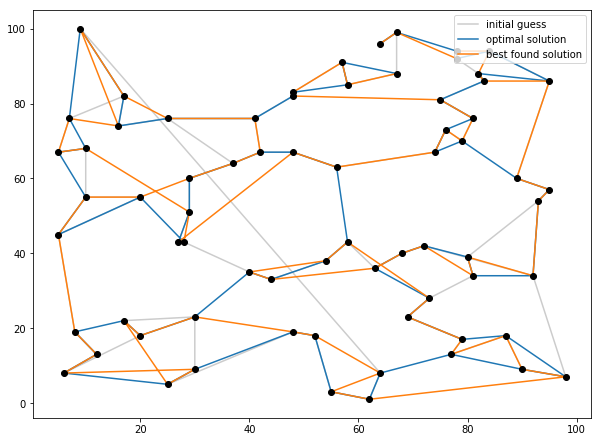

In [95]:
plottours(st70test)

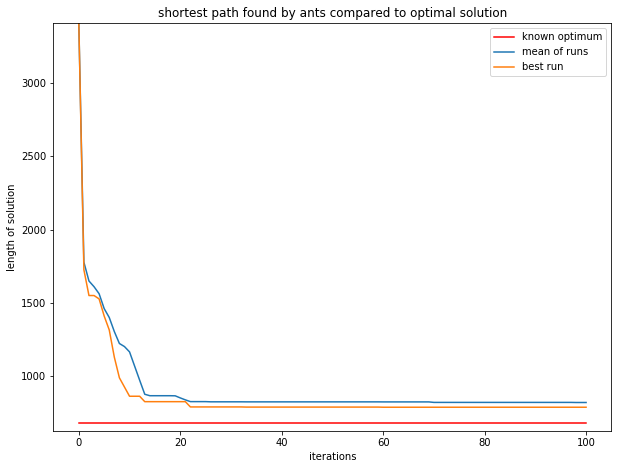

In [103]:
plotconvergence([st70test], mean = 'True')

In [104]:
berlin = AntOptimizer('berlin52', maxiterations = 100, antnumber = 50, solution = 'True')
berlin.optimization()


Ant colony optimization for Travelling Salesman problem:  berlin52 , with 50  ants

Initial guess by greedy strategy:  22205
Optimizing...

best solution found: 13314
known solution: 7542


In [107]:
berlin.optsamples(3)


Doing 3 runs of optimization...

Initial guess by greedy strategy:  22205
Optimizing...

best solution found: 8219
known solution: 7542

Initial guess by greedy strategy:  22205
Optimizing...

best solution found: 8187
known solution: 7542

Initial guess by greedy strategy:  22205
Optimizing...

best solution found: 8461
known solution: 7542


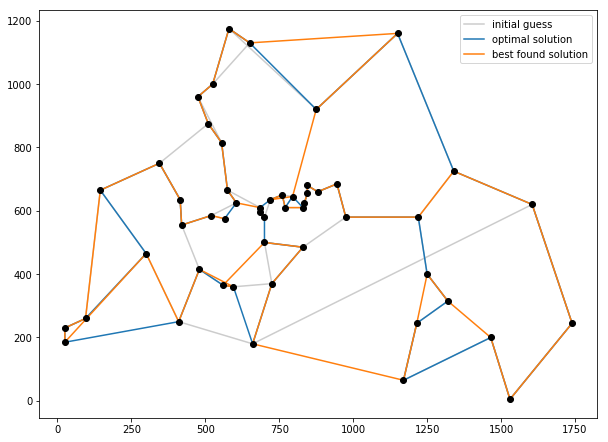

In [109]:
plottours(berlin)

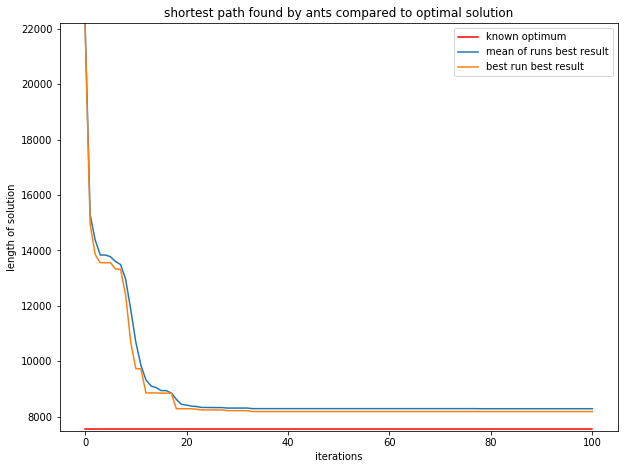

In [110]:
plotconvergence([berlin], mean= 'True', noteslist = ['best result'])

In [111]:
print(berlin.globalbestvalue)

8187


In [148]:
%%writefile variations.py
def vary_antnumber(problemname, maxiter, samples, str = 'minim'):

    opt_antnumber = []
    antno = [5, 10, 20, 50, 100]
    for an in antno:
        opt_antnumber.append(AntOptimizer(problemname, maxiterations = maxiter, antnumber = an, solution = 'True'))

    for opt in opt_antnumber:
        print(len(opt.pro.ants), 'ants; ', )
        opt.optsamples(samples)

    if str == 'mean':
        plotconvergence(opt_antnumber, mean='True', minim='False', noteslist = antno, title='shortest path found for different number of ants')
    else:
        plotconvergence(opt_antnumber, noteslist = antno)
        
#

Overwriting variations.py


In [149]:
%%writefile -a variations.py

#vary parameter alpha
def vary_alpha(problemname, maxiter, samples, str = 'minim'):

    opt_alpha = []
    alpha = [0.5, 0.75, 1.0, 1.25, 1.5]
    for a in alpha:
        opt_alpha.append(AntOptimizer(problemname, alpha = a, maxiterations = maxiter, antnumber = 50, solution = 'True'))

    for opt in opt_alpha:
        print('alpha: ', opt.pro.alpha )
        opt.optsamples(samples)

    if str == 'mean':
        plotconvergence(opt_alpha, mean='True', minim='False', noteslist = alpha, title=problemname +'; shortest path found for different values of alpha')
    else:
        plotconvergence(opt_alpha, noteslist = alpha, title=problemname +'; shortest path found for different values of alpha')
        
        #

Appending to variations.py


In [150]:
%%writefile -a variations.py
#vary parameter beta


def vary_beta(problemname, maxiter, samples, str = 'minim'):

    opt_alpha = []
    alpha = [1, 1.75, 2.5, 3.5, 5]
    for a in alpha:
        opt_alpha.append(AntOptimizer(problemname, beta = a, maxiterations = maxiter, antnumber = 50, solution = 'True'))

    for opt in opt_alpha:
        print('beta: ', opt.pro.beta )
        opt.optsamples(samples)

    if str == 'mean':
        plotconvergence(opt_alpha, mean='True', minim='False', noteslist = alpha, title=problemname +'; shortest path found for different values of beta')
    else:
        plotconvergence(opt_alpha, noteslist = alpha, title=problemname +'; shortest path found for different values of beta')
        
        #

Appending to variations.py


In [142]:
%%writefile -a variations.py

#vary parameter
def vary_ro(problemname, maxiter, samples, str = 'minim'):

    opt_alpha = []
    alpha = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8 ]
    for a in alpha:
        opt_alpha.append(AntOptimizer(problemname, ro = a, maxiterations = maxiter, antnumber = 50, solution = 'True'))

    for opt in opt_alpha:
        print('ro: ', opt.pro.ro )
        opt.optsamples(samples)

    if str == 'mean':
        plotconvergence(opt_alpha, mean='True', minim='False', noteslist = alpha, title=problemname +'; shortest path found for different values of ro')
    else:
        plotconvergence(opt_alpha, noteslist = alpha, title=problemname +'; shortest path found for different values of ro')

Appending to variations.py



Ant colony optimization for Travelling Salesman problem:  berlin52 , with 5  ants

Ant colony optimization for Travelling Salesman problem:  berlin52 , with 10  ants

Ant colony optimization for Travelling Salesman problem:  berlin52 , with 20  ants

Ant colony optimization for Travelling Salesman problem:  berlin52 , with 50  ants

Ant colony optimization for Travelling Salesman problem:  berlin52 , with 100  ants
5 ants; 

Doing 1 runs of optimization...

Initial guess by greedy strategy:  22205
Optimizing...

best solution found: 14229
known solution: 7542
10 ants; 

Doing 1 runs of optimization...

Initial guess by greedy strategy:  22205
Optimizing...

best solution found: 9115
known solution: 7542
20 ants; 

Doing 1 runs of optimization...

Initial guess by greedy strategy:  22205
Optimizing...

best solution found: 8704
known solution: 7542
50 ants; 

Doing 1 runs of optimization...

Initial guess by greedy strategy:  22205
Optimizing...

best solution found: 8137
known solutio

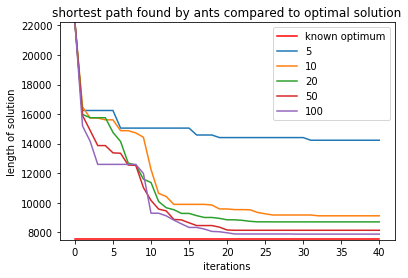

In [64]:
vary_antnumber('berlin52', 40, 1, str = 'minim')

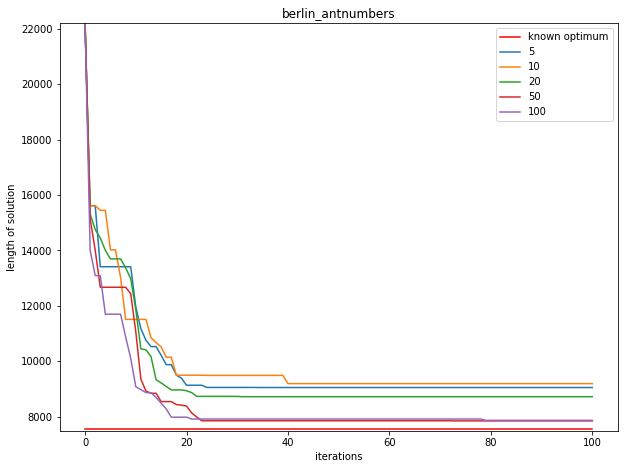

In [84]:
plotconvergence(opt_antnumber, noteslist = antno, title='berlin_antnumbers')


Ant colony optimization for Travelling Salesman problem:  berlin52 , with 50  ants

Ant colony optimization for Travelling Salesman problem:  berlin52 , with 50  ants

Ant colony optimization for Travelling Salesman problem:  berlin52 , with 50  ants

Ant colony optimization for Travelling Salesman problem:  berlin52 , with 50  ants

Ant colony optimization for Travelling Salesman problem:  berlin52 , with 50  ants
alpha:  0.5

Doing 5 runs of optimization...

Initial guess by greedy strategy:  22205
Optimizing...

best solution found: 9551
known solution: 7542

Initial guess by greedy strategy:  22205
Optimizing...

best solution found: 7838
known solution: 7542

Initial guess by greedy strategy:  22205
Optimizing...

best solution found: 12826
known solution: 7542

Initial guess by greedy strategy:  22205
Optimizing...

best solution found: 8637
known solution: 7542

Initial guess by greedy strategy:  22205
Optimizing...

best solution found: 8095
known solution: 7542
alpha:  0.75



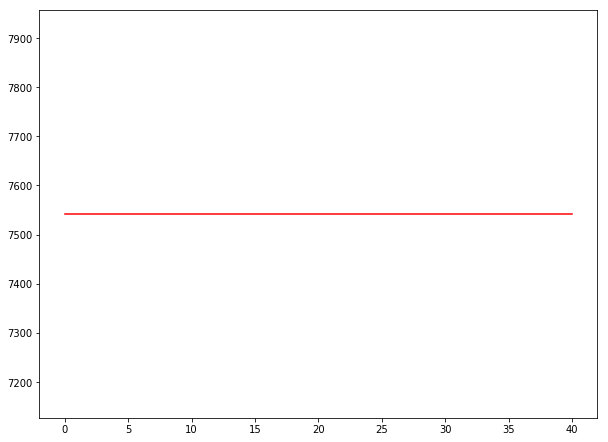

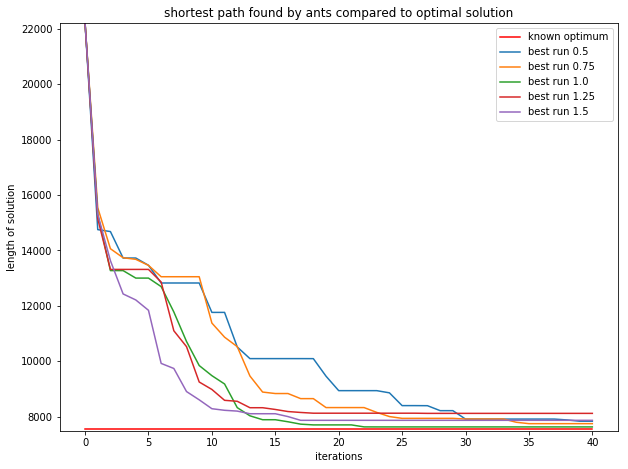

In [128]:
vary_alpha('berlin52', 40, 5, str='minim')

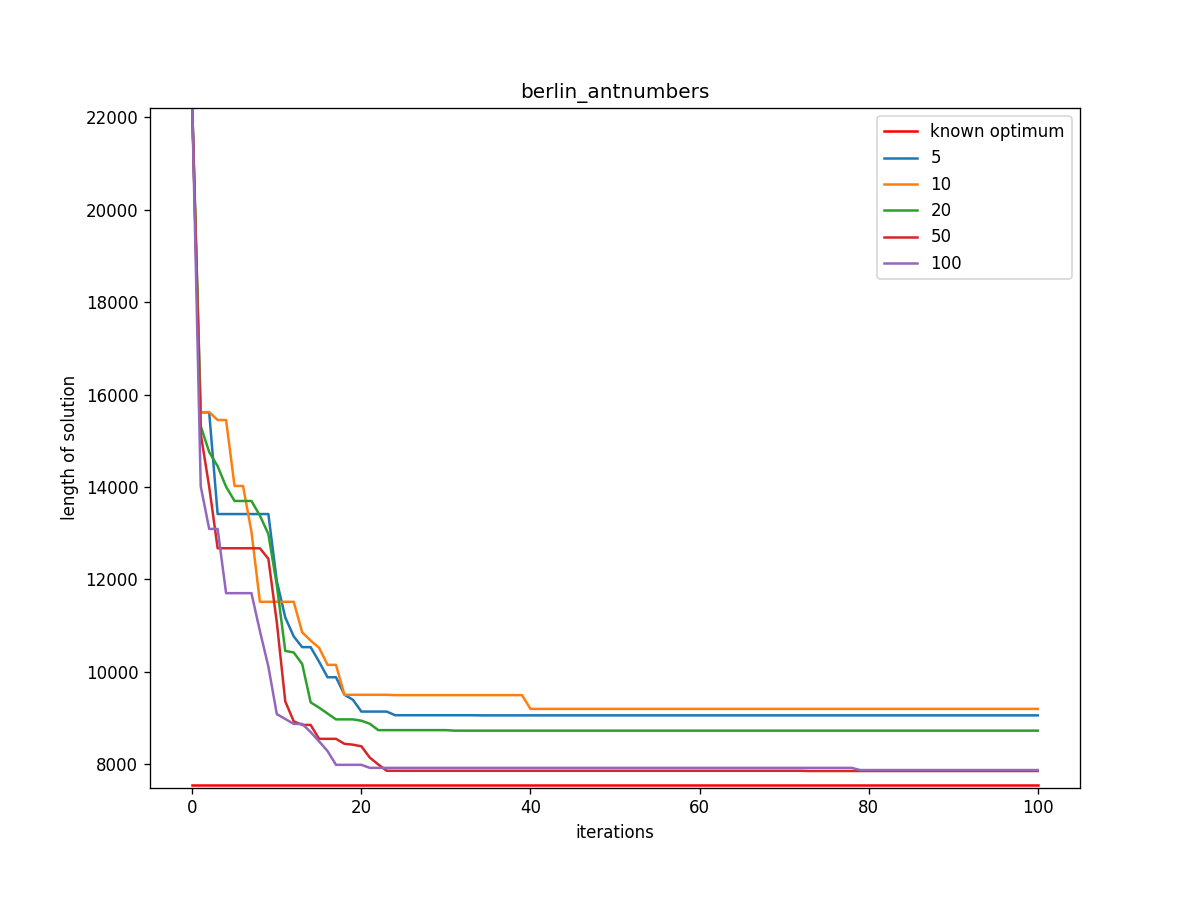

In [126]:
from IPython.display import Image
Image(filename="berlin_antnumbers.png")


Ant colony optimization for Travelling Salesman problem:  berlin52 , with 50  ants

Ant colony optimization for Travelling Salesman problem:  berlin52 , with 50  ants

Ant colony optimization for Travelling Salesman problem:  berlin52 , with 50  ants

Ant colony optimization for Travelling Salesman problem:  berlin52 , with 50  ants

Ant colony optimization for Travelling Salesman problem:  berlin52 , with 50  ants
beta:  1

Doing 5 runs of optimization...

Initial guess by greedy strategy:  22205
Optimizing...

best solution found: 16466
known solution: 7542

Initial guess by greedy strategy:  22205
Optimizing...

best solution found: 8861
known solution: 7542

Initial guess by greedy strategy:  22205
Optimizing...

best solution found: 9686
known solution: 7542

Initial guess by greedy strategy:  22205
Optimizing...

best solution found: 9088
known solution: 7542

Initial guess by greedy strategy:  22205
Optimizing...

best solution found: 9969
known solution: 7542
beta:  1.75

Doin

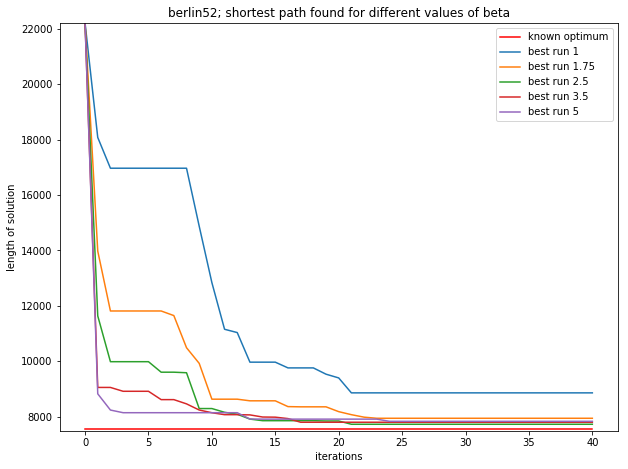

In [136]:
vary_beta('berlin52', 40, 5, str='minim')


Ant colony optimization for Travelling Salesman problem:  berlin52 , with 50  ants

Ant colony optimization for Travelling Salesman problem:  berlin52 , with 50  ants

Ant colony optimization for Travelling Salesman problem:  berlin52 , with 50  ants

Ant colony optimization for Travelling Salesman problem:  berlin52 , with 50  ants

Ant colony optimization for Travelling Salesman problem:  berlin52 , with 50  ants

Ant colony optimization for Travelling Salesman problem:  berlin52 , with 50  ants

Ant colony optimization for Travelling Salesman problem:  berlin52 , with 50  ants
ro:  0.2

Doing 5 runs of optimization...

Initial guess by greedy strategy:  22205
Optimizing...

best solution found: 9256
known solution: 7542

Initial guess by greedy strategy:  22205
Optimizing...

best solution found: 13192
known solution: 7542

Initial guess by greedy strategy:  22205
Optimizing...

best solution found: 13719
known solution: 7542

Initial guess by greedy strategy:  22205
Optimizing...


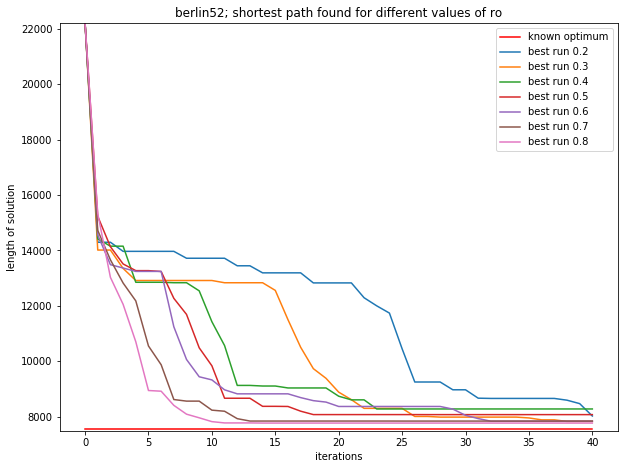

In [138]:
vary_ro('berlin52', 40, 5, str='minim')